In [32]:
# Import packages

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
from matplotlib import rc
import seaborn as sns

from scipy.optimize import curve_fit

# Set the global font to be Arial, size 10
rc('font',**{'family':'sans-serif','sans-serif':['Arial'],'size':15})

In [33]:
# Import data

data = pd.read_csv("datasets/import_data_example.csv")
noise = pd.read_csv("datasets/noise.csv")

interval = 30 # aquisition interval in seconds
frame = 20
for i in range(data.shape[0]):
    data.loc[i,'Time'] = i*interval/60 - frame*interval/60
    
for i in range(data.shape[0]):
    data.loc[i,'Subtracted'] = data.loc[i,'Mean'] - noise.iloc[0,1]
    
display(data.head(5))

,,Area,Mean,Min,Max,Slice,cm,Time,Subtracted
0,1,2.693,1245.019,680,2338,1,0,-10.0,745.081
1,2,2.693,1292.007,665,2373,2,1,-9.5,792.069
2,3,2.693,1302.589,678,38456,3,2,-9.0,802.651
3,4,2.693,1313.071,708,2514,4,3,-8.5,813.133
4,5,2.693,1315.180,696,2374,5,4,-8.0,815.242


In [34]:
# Define Gompertz function. Gompertz function fits non-symmetric sigmoidal function, see Tjorve & Tjorve, 2017: https://www.ncbi.nlm.nih.gov/pubmed/28582419

def gomp(x, A, B, Ti, ku):
    return B + (A - B) * np.exp(-np.exp(- np.e*ku * (x - Ti)))

# Set inital guesses

B = 0
A = max(data['Mean'])
Ti = 4
ku = 0.01
guess = np.array([A, B, Ti, ku])

# Fit the function from the point of GEF addition (20)

popt, pcov = curve_fit(gomp, data.loc[20:,'Time'], data.loc[20:,'Subtracted'], guess, bounds = ((0, -np.inf, 0, 0), (np.inf, np.inf, np.inf, np.inf)))
perr = np.sqrt(np.diag(pcov))

print(" A = {0:.2f} +- {1:.2f}, B = {2:.2f} +- {3:.2f} \n".format(popt[0], perr[0], popt[1], perr[1]), 
      "Ti = {0:.3f} +- {1:.3f} min \n".format(popt[2], perr[2]),
      "ku = {0:.5f} +- {1:.5f}".format(popt[3], perr[3])) 
                                                                  
# Normalize the data to the upper asymptote A

for i in range(data.shape[0]):
    data.loc[i,'Norm'] = data.loc[i,'Subtracted']/popt[0]
display(data.head(5))

 A = 9320.00 +- 117.87, B = -124.28 +- 1256.73 
 Ti = 1.517 +- 0.630 min 
 ku = 0.14326 +- 0.01592


,,Area,Mean,Min,Max,Slice,cm,Time,Subtracted,Norm
0,1,2.693,1245.019,680,2338,1,0,-10.0,745.081,0.079944
1,2,2.693,1292.007,665,2373,2,1,-9.5,792.069,0.084986
2,3,2.693,1302.589,678,38456,3,2,-9.0,802.651,0.086121
3,4,2.693,1313.071,708,2514,4,3,-8.5,813.133,0.087246
4,5,2.693,1315.180,696,2374,5,4,-8.0,815.242,0.087472


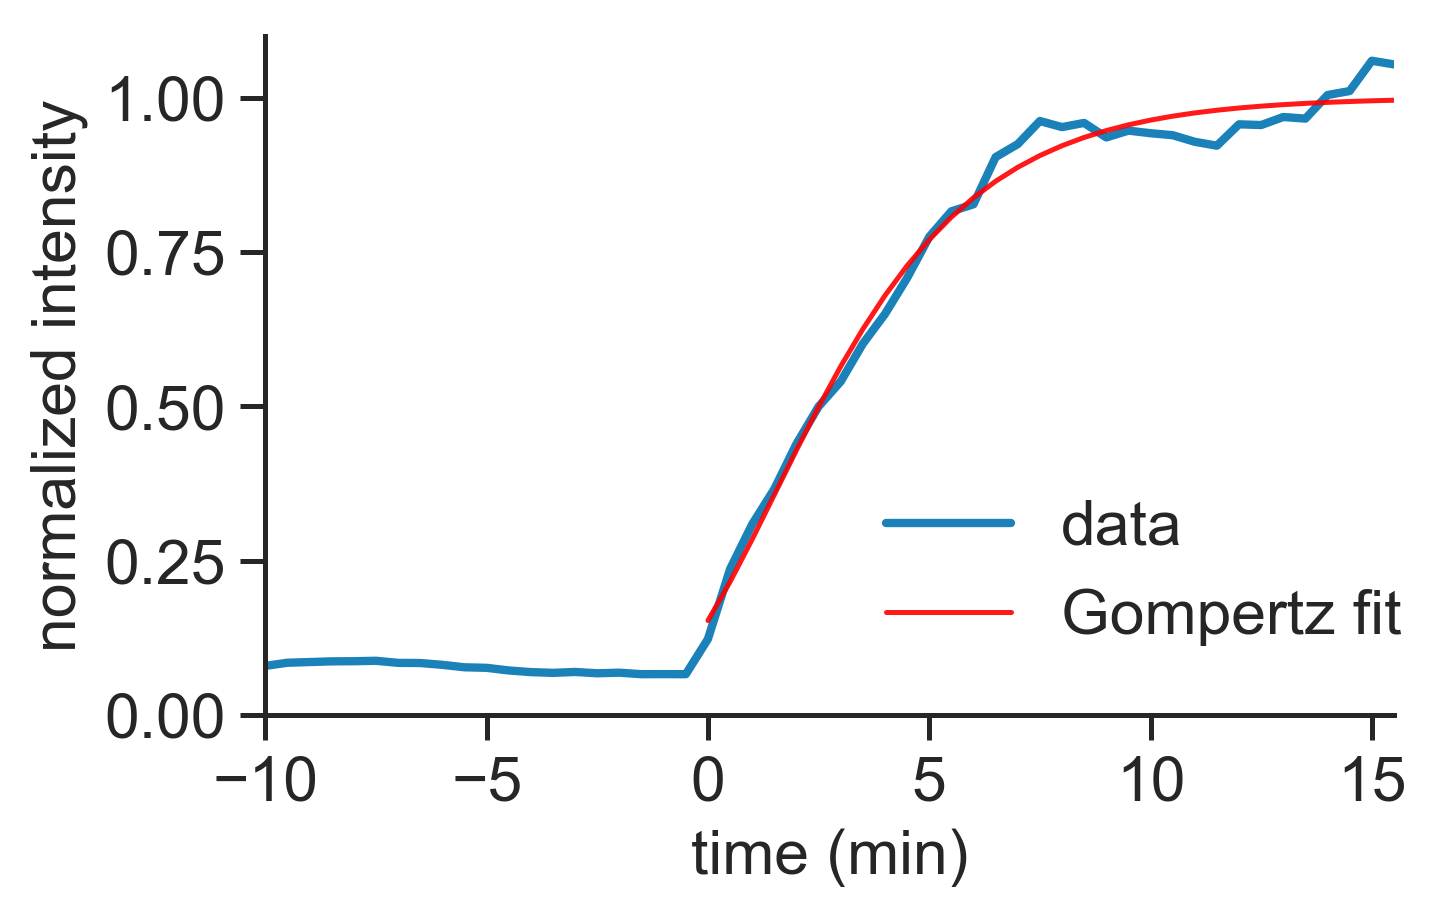

In [35]:
#### PLOT ####

sns.set(style="ticks", palette="colorblind")

fig = plt.figure(figsize=(3*1.618,3), dpi = 300) # golden ratio
ax1 = fig.add_subplot(111)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax1.tick_params('both', length=6, width=1.2, which='major')
ax1.tick_params('both', length=4, width=1.2, which='minor')

for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(1.2)   

palette = sns.color_palette(n_colors=10)

ax1.plot(data['Time'], data['Norm'], linewidth=2.0, alpha=0.9, label='data')
ax1.plot(data.loc[20:,'Time'], gomp(data.loc[20:,'Time'], *popt)/popt[0], linewidth=1.2, c='red',linestyle='-', alpha=0.9, label = 'Gompertz fit')

ax1.legend(bbox_to_anchor=(0.5, 0.4),fontsize=15, frameon=False)

ax1.set_ylim([0, 1.1])

ax1.autoscale(enable=True, axis='x', tight=True)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
locx = ticker.MultipleLocator(base=5) # this locator puts ticks at regular intervals
ax1.xaxis.set_major_locator(locx)
locy = ticker.MultipleLocator(base=0.25) # this locator puts ticks at regular intervals
ax1.yaxis.set_major_locator(locy)

ax1.set_xlabel("time (min)", fontsize=15)
ax1.set_ylabel("normalized intensity", fontsize=15)

plt.rcParams.update({'mathtext.default':  'regular', "svg.fonttype": 'none' })

sns.despine()